# Imports

In [141]:
import os
from functools import partial
import json

import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import random

from gerrychain import (
    Election,
    Graph,
    MarkovChain,
    Partition,
    accept,
    constraints,
    updaters,
)

from gerrychain.metrics import efficiency_gap, mean_median, partisan_gini
from gerrychain.proposals import recom
from gerrychain.updaters import cut_edges
from gerrychain.tree import recursive_tree_part

# Downloading state data

In [191]:
graph_path = "./massachusetts.json"
graph = Graph.from_json(graph_path)
with open (graph_path, "r") as myfile:
    data=myfile.readlines()
graph_dict = json.loads(data[0])

# Chain stuff

In [192]:
election = "SEN14"

In [193]:
pop_count = 0

for i in graph.nodes:
    pop_count += graph.nodes[i]["TOTPOP"]
    
print(pop_count)

6728169.714491896


In [194]:
for n in graph.nodes:
    graph.nodes[n][election+"D"] = int(graph.nodes[n][election+"D"].replace(",",""))
    graph.nodes[n][election+"R"] = int(graph.nodes[n][election+"R"].replace(",",""))

In [149]:
graph.nodes[0]

{'boundary_node': True,
 'boundary_perim': 0.14079928066162706,
 'area': 0.0006839594270970608,
 'District': '1-1',
 'Name': 'Boston Ward 1 Precinct 1',
 'Shape_Le_1': 0.2370997653,
 'Shape_Area': 0.00068395943,
 'City/Town': 'Boston',
 'Ward': '1',
 'Pct': '1',
 'SEN12D': '604',
 'SEN12R': '251',
 'PRES12D': '645',
 'PRES12R': '188',
 'SEN13D': '241',
 'SEN13R': '84',
 'SEN14D': 439,
 'SEN14R': 109,
 'PRES16D': '755',
 'PRES16R': '189',
 'CD': '07',
 'TOTPOP': 2127.1376074597397,
 'NH_WHITE': 1232.8953012907173,
 'NH_BLACK': 58.91581379295309,
 'NH_AMIN': 11.999999891822892,
 'NH_ASIAN': 66.91581078543187,
 'NH_NHPI': 1.000000016734194,
 'NH_OTHER': 44.747434355389224,
 'HISP': 710.6632473266911,
 'H_WHITE': 428.83162612047374,
 'H_BLACK': 37.00000046135009,
 'H_AMIN': 4.999999662849095,
 'H_ASIAN': 5.999999756691586,
 'H_NHPI': 4.999999786413395,
 'H_OTHER': 228.83162153891337,
 'VAP': 1714.474357046681,
 'HVAP': 502.8316220818222,
 'WVAP': 1071.8952982689327,
 'BVAP': 37.91581339079

In [205]:
%%time
num_dist = 9

# Exercise: Compute exact population from your data.
pop = pop_count

my_updaters = {
    "population": updaters.Tally("TOTPOP", alias="population"),
    "cut_edges": cut_edges,
    election: Election(election, {"democratic":"SEN14D","republican":"SEN14R"})
}


new_plan = recursive_tree_part(graph,
                               range(num_dist),
                               pop/num_dist,
                               "TOTPOP",
                               0.005,
                               3)
initial_partition = Partition(graph,
                              new_plan,
                              my_updaters)

CPU times: user 2.78 s, sys: 17.9 ms, total: 2.79 s
Wall time: 2.83 s


In [206]:
%%time
proposal = partial(recom,
                   pop_col = "TOTPOP",
                   pop_target = pop/num_dist,
                   epsilon = 0.009,
                   node_repeats = 3)

compactness_bound = constraints.UpperBound(
    lambda p: len(p["cut_edges"]), 2 * len(initial_partition["cut_edges"])
)

CPU times: user 21.8 ms, sys: 1.23 ms, total: 23 ms
Wall time: 22.8 ms


## Acceptance Functions

In [58]:
%%time
def push_rep(partition):
    bound = 1
    if partition.parent is not None:
        if sorted(partition.parent[election].percents("republican"))[-1] >= sorted(partition[election].percents("republican"))[-1]:
            bound = 0
    return random.random() < bound

CPU times: user 9 µs, sys: 1e+03 ns, total: 10 µs
Wall time: 17.2 µs


In [59]:
%%time
def one_rep(partition):
    bound = 1
    if partition.parent is not None:
        if sorted(partition.parent[election].percents("republican"))[-1] < 0.5:
            if sorted(partition.parent[election].percents("republican"))[-1] >= sorted(partition[election].percents("republican"))[-1]:
                bound = 0
        else:
            if sorted(partition[election].percents("republican"))[-1] < 0.5:
                bound = 0      
    return random.random() < bound

CPU times: user 7 µs, sys: 1e+03 ns, total: 8 µs
Wall time: 13.1 µs


In [155]:
%%time
def two_rep(partition):
    parent_percents = sorted(partition.parent[election].percents("republican"), reverse=True)
    percents = sorted(partition[election].percents("republican"), reverse=True)
    
    bound = 1
    
    if partition.parent is not None:
        if parent_percents[0] < 0.5:
            if parent_percents[0] >= percents[0]:
                bound = 0
        else:
            if percents[0] < 0.5:
                bound = 0
            else:
                if parent_percents[1] < 0.5:
                    if parent_percents[1] >= percents[1]:
                        bound = 0
                    else:
                        if percents[1] < 0.5:
                            bound = 0
                            
    return random.random() < bound

CPU times: user 5 µs, sys: 1e+03 ns, total: 6 µs
Wall time: 11 µs


In [177]:
%%time
def two_rep_probabalistic(partition):
    parent_percents = sorted(partition.parent[election].percents("republican"), reverse=True)
    percents = sorted(partition[election].percents("republican"), reverse=True)
    
    bound = 1
    
    if partition.parent is not None:
        if parent_percents[0] < 0.5:
            if parent_percents[0] >= percents[0]:
                bound = 5 * (parent_percents[0] - percents[0])
        else:
            if percents[0] < 0.5:
                bound = 0
            else:
                if parent_percents[1] < 0.5:
                    if parent_percents[1] >= percents[1]:
                        bound = 5 * (parent_percents[1] - percents[1])
                    else:
                        if percents[1] < 0.5:
                            bound = 0
                            
    return random.random() < bound

CPU times: user 6 µs, sys: 1 µs, total: 7 µs
Wall time: 11.2 µs


# Pulling data from chain run

In [ ]:
%%time

good_step = Partition(graph,
                     dict(step.assignment),
                     my_updaters)

chain = MarkovChain(
    proposal=proposal,
    constraints=[
        constraints.within_percent_of_ideal_population(initial_partition, 0.01),
        compactness_bound,
    ],
    accept=two_rep_probabalistic,
    initial_state=good_step,
    total_steps=5000,
)

data = []

for step in tqdm_notebook(chain):
    data.append([step[election].wins("republican"),
                         mean_median(step[election]),
                         partisan_gini(step[election]),
                         step[election].percents("republican")])

# Visualization

CPU times: user 24.7 ms, sys: 2.8 ms, total: 27.5 ms
Wall time: 57.8 ms


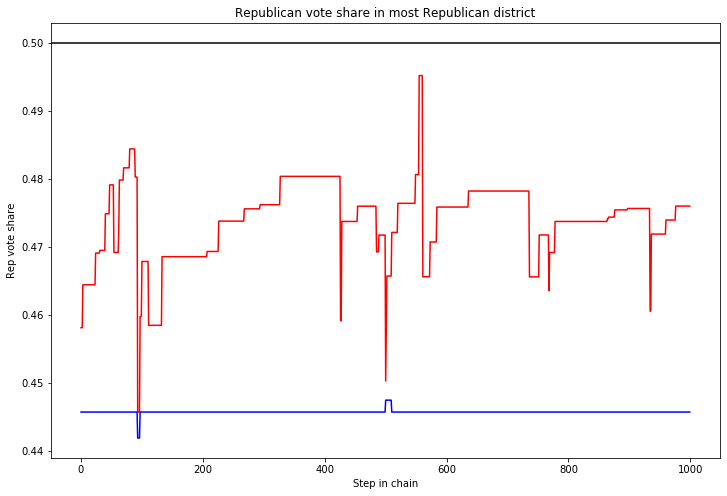

In [208]:
%%time
fig, rep_dist = plt.subplots(figsize=(12,8))

most_rep_dist = []
secmost_rep_dist = []
one_rep_plans = []

for plan in data:
    most_rep_dist.append(sorted(plan[3])[-1])
    secmost_rep_dist.append(sorted(plan[3])[-2])
    if sorted(plan[3])[-1] >= 0.5:
        one_rep_plans.append(plan)
    
rep_dist.plot(most_rep_dist, color="red")
rep_dist.plot(secmost_rep_dist, color="blue")
rep_dist.set_title("Republican vote share in most Republican district")
rep_dist.set_ylabel("Rep vote share")
rep_dist.set_xlabel("Step in chain")
rep_dist.axhline(y = 0.5, color="black")
# rep_dist.set_ylim(.495,.52)

In [67]:
len(one_rep_plans)

4541

In [68]:
copy_orp = one_rep_plans.copy()

In [69]:
len(copy_orp)

4541


CPU times: user 302 ms, sys: 20.2 ms, total: 322 ms
Wall time: 254 ms


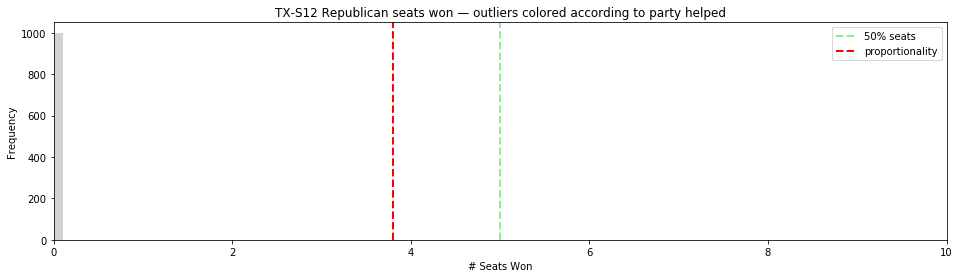

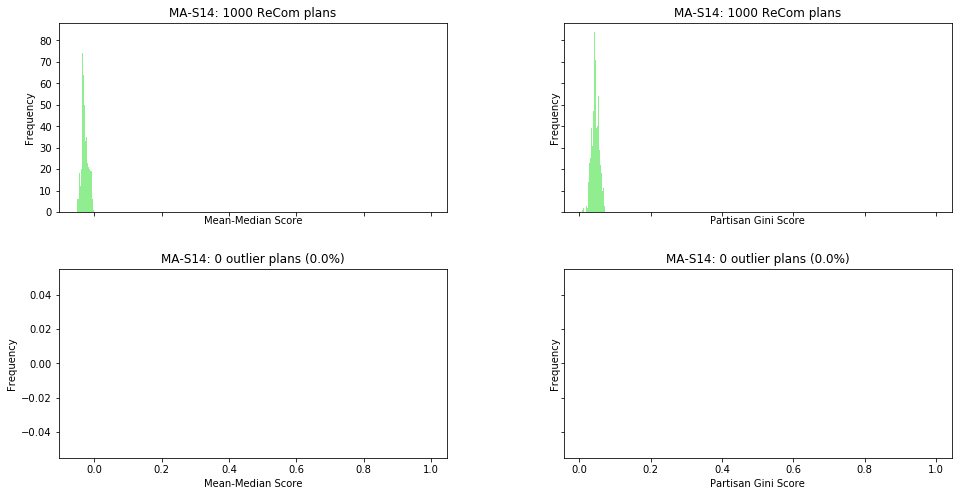

In [25]:
%%time
# fig, votes = plt.subplots(figsize=(16,4))
fig, seats = plt.subplots(figsize=(16,4))
fig, ax = plt.subplots(2,2, figsize=(16,8), sharex="col", sharey="row")

plt.subplots_adjust(wspace=0.3, hspace=0.3)

# Variables
inliers = [0,0]
bins_num = 20
out_bins_num = 10
title = "MA-S14: 5000 ReCom plans"

# Colors
seats_colors = ["red", "blue", "lightgray"]
party_colors = ["red", "blue"]
neutral = "lightgreen"

# Creating Datasets
mm = []
pg = []
vs = []
mm_routliers = []
mm_doutliers = []
pg_routliers = []
pg_doutliers = []
seats_routliers = []
seats_doutliers = []
seats_inliers = []
vs_routliers = []
vs_doutliers = []


for plan in tqdm_notebook(data):
    mm.append(plan[1])
    pg.append(plan[2])
    vs.append(plan[3])
    if plan[0] < inliers[0]:
        seats_doutliers.append(plan[0])
        mm_doutliers.append(plan[1])
        pg_doutliers.append(plan[2])
        vs_doutliers.append(plan[3])
    if plan[0] > inliers[1]:
        seats_routliers.append(plan[0])
        mm_routliers.append(plan[1])
        pg_routliers.append(plan[2])
        vs_routliers.append(plan[3])
    if plan[0] >= inliers[0] and plan[0] <= inliers[1]:
        seats_inliers.append(plan[0])

mms = [mm_routliers, mm_doutliers]
pgs = [pg_routliers, pg_doutliers]
seats_colored = [seats_routliers, seats_doutliers, seats_inliers]

# More variables
num_outliers = str(len(mm_doutliers) + len(mm_routliers))
pct_outliers = str(round((len(mm_doutliers) + len(mm_routliers)) / 1000 * 100, 1))
title_w = "MA-S14: " + num_outliers + " outlier plans " + "(" + pct_outliers + "%)"

# Plotting the votes shares boxplots
# votes.boxplot(vs, positions=range(len(data.columns)))

# votes.set_title("Votes Shares Boxplots")
# votes.set_ylabel("Republican Votes %")
# votes.set_xlabel("District #")


# Plotting the seats histogram
seats.hist(seats_colored, bins=out_bins_num, stacked=True, color=seats_colors)

seats.set_title("MA-S14 Republican seats won — outliers colored according to party helped")
seats.set_ylabel("Frequency")
seats.set_xlabel("# Seats Won")
seats.set_xlim(0, num_dist)
seats.axvline(x = num_dist/2, color=neutral, linestyle="dashed", linewidth=2, label="50% seats")
seats.axvline(x = num_dist * initial_partition[election].percent("republican"), color="red", linestyle="dashed", linewidth=2, label="proportionality")
seats.legend()
# seats.set_xticks(1)

# Plotting the whole dataset
ax[0,0].hist(mm, bins=2*bins_num, color=neutral)
ax[0,1].hist(pg, bins=2*bins_num, color=neutral)

ax[0,0].set_title(title)
ax[0,0].set_ylabel("Frequency")
ax[0,0].set_xlabel("Mean-Median Score")

ax[0,1].set_title(title)
ax[0,1].set_ylabel("Frequency")
ax[0,1].set_xlabel("Partisan Gini Score")

# Plotting the winnowed data
ax[1,0].hist(mms, bins=bins_num, color=party_colors)
ax[1,1].hist(pgs, bins=bins_num, color=party_colors)
# ax[1,1].set_ylim((0,40))

ax[1,0].set_title(title_w)
ax[1,0].set_ylabel("Frequency")
ax[1,0].set_xlabel("Mean-Median Score")

ax[1,1].set_title(title_w)
ax[1,1].set_ylabel("Frequency")
ax[1,1].set_xlabel("Partisan Gini Score")